# Introduction

Addressing credit card fraud is a top priority for financial institutions, given the constant threat it poses to consumers and businesses. In Brazil alone, Serasa Experian reports that approximately 12.1 million people fell victim to financial fraud in the past year, resulting in a total loss of 1.8 billion reais over the last 12 months.

Effectively detecting fraud is a significant challenge, as legitimate and fraudulent transactions often bear similarities. The complexity is further heightened by the diversity of values and locations where fraud can occur, making pattern recognition challenging. This difficulty can lead to errors in both false positives, such as the preventive blocking of consumer cards, and false negatives, where fraudulent transactions go undetected.

To address this issue, it is crucial to continually enhance security systems, adopt advanced detection technologies, and invest in more robust authentication methods. Collaboration between financial institutions, regulators, and technology companies plays a pivotal role in developing more effective solutions to mitigate the risks associated with credit card fraud.

# Objectives

The objective of this project is to conduct an exploratory data analysis and build machine learning models capable of accurately detecting fraudulent transactions. To achieve this, advanced data analysis and machine learning techniques will be employed to identify patterns and anomalies in the data, along with data balancing techniques. Additionally, it will be crucial to assess the effectiveness of the constructed models, both in terms of accuracy in fraud detection and the minimization of false positives.

# Business Understanding

Fraudulent transactions involve the illicit acquisition of goods and services using stolen payment information. As credit card usage continues to rise, both online and offline, associated fraud activities also escalate. It is crucial for businesses to comprehend this threat, its various forms, and metrics to effectively monitor and combat such activities.

There're some Key Performance Indicators (KPIs) that is important to understand:
* **Acceptance**: The volume of transactions accepted after authorization and screening.
* **Challenges**: Transactions flagged as potentially fraudulent and subject to manual review.
* **Denials**: Payment requests rejected by the acquirer or identified as fraud before processing.
* **Chargebacks**: Transactions identified as fraud by the acquirer or contested by the customer.
* **False Positives**: Legitimate customer transactions incorrectly blocked as fraud.

Effective fraud management hinges on monitoring these KPIs diligently. Elevated false positive rates, for instance, can lead to lost sales and frustrated customers. Therefore, beyond safeguarding against fraud, companies must ensure their fraud detection solutions don't deter legitimate customers.

For this project, it is known that the company earns 10% of the value for a correctly approved payment and loses 100% in case of fraud:

* **Fraud Rate**: fraudulent transactions approved / total transactions approved
* **Approval Rate**: total transactions approved / transactions received



In [27]:
# Bibliotecas padrão
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow 
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import plotly.io as pio
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import plotly as ply

# Visualização de dados
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import missingno

# Testes estatísticos
from scipy.stats import chi2_contingency, mannwhitneyu
import scipy.stats as stats

# Modelos de machine learning e utilitários
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import (roc_curve, auc, confusion_matrix, log_loss, roc_auc_score,
                             precision_score, recall_score, f1_score, make_scorer)
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce

# Classificadores e métodos de ensemble
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
file_path = "data/fraud_data.xlsx"

df = df = pd.read_excel(file_path)
df.head()

,score_1,score_2,score_3,score_4,score_5,score_6,pais,score_7,produto,categoria_produto,score_8,score_9,score_10,entrega_doc_1,entrega_doc_2,entrega_doc_3,data_compra,valor_compra,score_fraude_modelo,fraude
0,4.0,0.7685,94436.24,20.0,0.444828,1.0,BR,5.0,Máquininha Corta Barba Cabelo Peito Perna Pelo...,cat_8d714cd,0.883598,240.0,102.0,1.0,NaN,N,2020-03-27 11:51:16,5.64,66.0,0.0
1,4.0,0.7550,9258.50,1.0,0.000000,33.0,BR,0.0,Avental Descartavel Manga Longa - 50 Un. Tnt ...,cat_64b574b,0.376019,4008.0,0.0,1.0,Y,N,2020-04-15 19:58:08,124.71,72.0,0.0
2,4.0,0.7455,242549.09,3.0,0.000000,19.0,AR,23.0,Bicicleta Mountain Fire Bird Rodado 29 Alumini...,cat_e9110c5,0.516368,1779.0,77.0,1.0,NaN,N,2020-03-25 18:13:38,339.32,95.0,0.0
3,4.0,0.7631,18923.90,50.0,0.482385,18.0,BR,23.0,Caneta Delineador Carimbo Olho Gatinho Longo 2...,cat_d06e653,0.154036,1704.0,1147.0,1.0,NaN,Y,2020-04-16 16:03:10,3.54,2.0,0.0
4,2.0,0.7315,5728.68,15.0,0.000000,1.0,BR,2.0,Resident Evil Operation Raccoon City Ps3,cat_6c4cfdc,0.855798,1025.0,150.0,1.0,NaN,N,2020-04-02 10:24:45,3.53,76.0,0.0


In [12]:
print(df.shape)

(150000, 20)


# Dataset Dictionary

- **`score_1` a `score_10`**: 
  - Description: Credit bureau scores.
  - Purpose: Used to assess the buyer's reliability.
  
- **`Pais` (`Country`)**: 
  - Description: Country where the purchase was made.

- **`Produto` (`Product`)**: 
  - Description: Specific item acquired on the e-commerce platform.

- **`Categoria_produto` (`Produc Category`)**: 
  - Description: Classification of the product within the e-commerce platform.

- **`Entrega_doc_1` a `entrega_doc_3` (`Document Delivery Indicators`)**: 
  - Description: Indicators of document delivery at the account creation stage.
  - Values: 
    - **0** or **N**: Did not deliver.
    - **1** or **Y**: Delivered.
    - Blank: Considered as not delivered.

- **`Score_fraude_modelo` (`Fraud Model Score`)**: 
  - Description: Probability, provided by the current model, of a purchase being fraudulent.
  - Values: Ranges from 0 to 100. The closer to 100, the higher the model's confidence that the transaction is fraudulent.

- **`Fraude` (`Fraud`)**: 
  - Description: Verification of the authenticity of the purchase.
  - Valores: 
    - **0**: Legitimate transaction.
    - **1**: Fraudulent transaction.
  - Note: This information is confirmed a few days after the transaction to ensure accuracy.


# Data Exploratory Analysis

In [18]:
# Visualizar o tamanho do dataframe
print(f"Number of samples: {df.shape[0]}")
print(f"Number of variables: {df.shape[1]}")

Number of samples: 150000
Number of variables: 20


In [19]:
df.columns

Index(['score_1', 'score_2', 'score_3', 'score_4', 'score_5', 'score_6',
       'pais', 'score_7', 'produto', 'categoria_produto', 'score_8', 'score_9',
       'score_10', 'entrega_doc_1', 'entrega_doc_2', 'entrega_doc_3',
       'data_compra', 'valor_compra', 'score_fraude_modelo', 'fraude'],
      dtype='object')

In [20]:
df.dtypes

score_1                       float64
score_2                       float64
score_3                       float64
score_4                       float64
score_5                       float64
score_6                       float64
pais                           object
score_7                       float64
produto                        object
categoria_produto              object
score_8                       float64
score_9                       float64
score_10                      float64
entrega_doc_1                 float64
entrega_doc_2                  object
entrega_doc_3                  object
data_compra            datetime64[ns]
valor_compra                  float64
score_fraude_modelo           float64
fraude                        float64
dtype: object

## Null values

In [22]:
## percentage of null values
df.isnull().mean() * 100

score_1                 0.000000
score_2                 8.656000
score_3                 8.656000
score_4                 0.243333
score_5                 0.000000
score_6                 0.007333
pais                    0.129333
score_7                 0.000000
produto                 0.000000
categoria_produto       0.000000
score_8                 0.000000
score_9                 0.007333
score_10                0.243333
entrega_doc_1           0.000000
entrega_doc_2          72.571333
entrega_doc_3           0.000000
data_compra             0.000000
valor_compra            0.000000
score_fraude_modelo     0.000000
fraude                  0.000000
dtype: float64

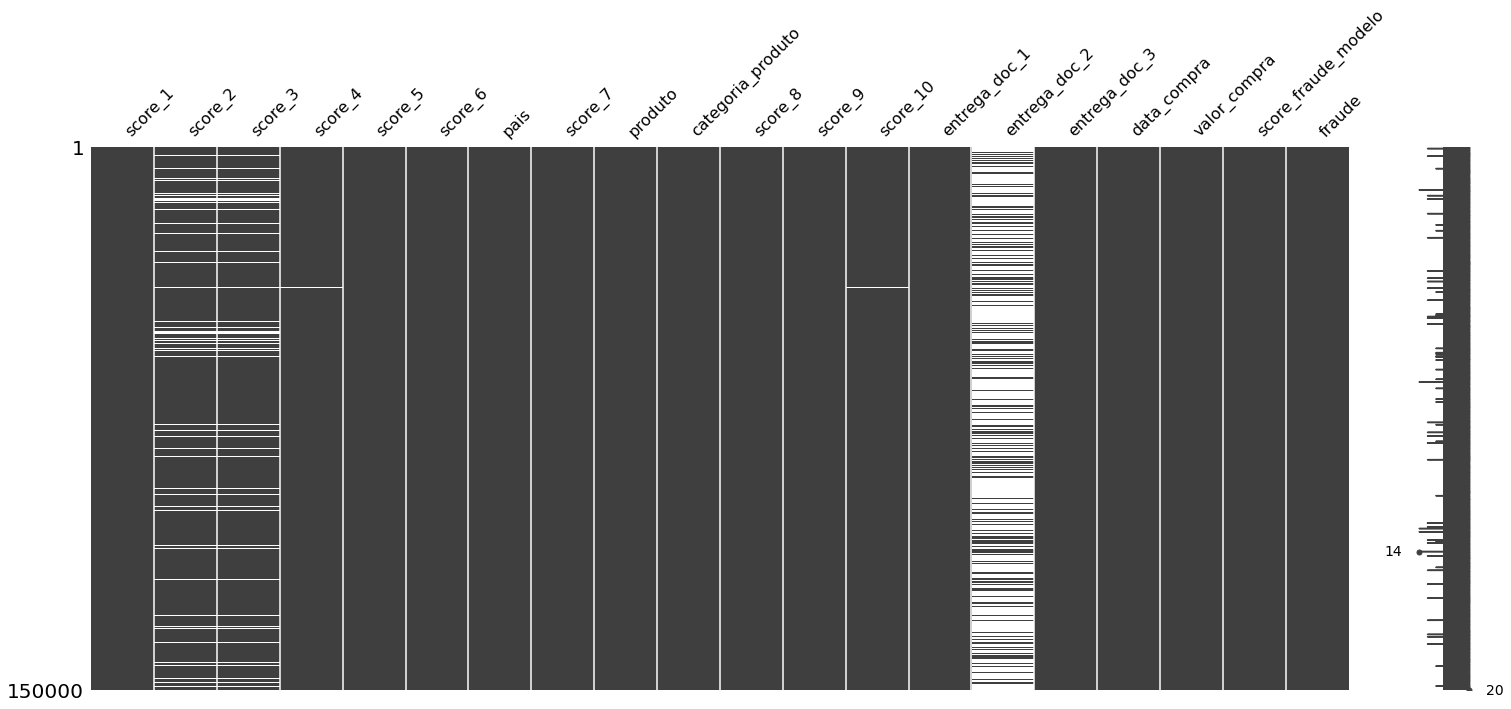

In [23]:
missingno.matrix(df);

The column `entrega_doc_2`, as previously observed, has 72% of null entries. In this context, null values may indicate individuals who did not deliver the required documents. However, this lack of document submission can potentially aid in detecting fraudsters. In such instances, it is advisable to create a new boolean feature (column) indicating whether the document was delivered or not (1: delivered, 0: null entry).

## Univariate Data Analysis

As the variable score_1 ranges from 1 to 4, I will consider it categorical. Below is a bar chart representing this distribution.

In [38]:
import plotly.express as px
import plotly.graph_objects as go

# Assuming df is your DataFrame
fig = px.histogram(df, x='score_1', color_discrete_sequence=["#001F3F", "#AAAAAA", "#334C66", "#7D99A8", "#D0D0D0"])

fig.update_layout(
    template="plotly_white",
    xaxis_title="Score_1",
    yaxis_title="Quantidade",
    title="Quantidade x Score_1"
)

fig.show()


It is possible to observe that the majority of users belong to category 4.

In [76]:
fraud_df = df[df['fraude'] == 1]

colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

fig = px.bar(
    fraud_df['score_1'].value_counts(normalize=True).reset_index(),
    x='index',
    y='score_1',
    labels={'index': 'Score_1', 'score_1': 'Porcentagem de Fraudes'},
)

fig.update_layout(
    xaxis_title="Score_1",
    yaxis_title="Porcentagem de Fraudes",
    title="Porcentagem de Fraudes x Score_1"
)

fig.show()


Similarly, the majority of frauds are allocated in categories 4 and 2. Now, let's examine the cardinality of the `country` variable.

In [77]:
## count the percentage of samples in each contry (pais), and plot a bar chart using plotly
fig = px.bar(
    df['pais'].value_counts(normalize=True).reset_index(),
    x='index',
    y='pais',
    labels={'index': 'Pais', 'pais': 'Porcentagem'},
)

fig.update_layout(
    xaxis_title="Pais",
    yaxis_title="Porcentagem",
    title="Porcentagem x Pais"
)

fig.show()

In [78]:
len(df['pais'].unique())

52

In [83]:
fraud_df['pais'].value_counts(normalize=True)

BR    0.823246
AR    0.157515
US    0.009352
UY    0.003874
SE    0.002004
RU    0.000802
ES    0.000668
MX    0.000401
FR    0.000401
DE    0.000401
EC    0.000267
NL    0.000267
KR    0.000134
CO    0.000134
NZ    0.000134
FI    0.000134
CL    0.000134
PT    0.000134
Name: pais, dtype: float64

In [82]:
## now count the percentage of samples in each contry (pais) that happened a fraud (fraude = 1), plot a bar chart using plotly
## pais with fraude = 1 / pais total

fig = px.bar(
    fraud_df['pais'].value_counts(normalize=True).reset_index(),
    x='index',
    y='pais',
    labels={'index': 'Pais', 'pais': 'Porcentagem de Fraudes'},
)

fig.update_layout(
    xaxis_title="Pais",
    yaxis_title="Porcentagem de Fraudes",
    title="Porcentagem de Fraudes x Pais"
)

fig.show()

There are 52 countries in the dataset, where Brazil and Argentina together represent more than 90% of the dataset.

Now, let's consider the `product` variable

In [89]:
## count amount of products (produto)
print(f'amount of products: {len(df["produto"].unique())}')
df['produto'].value_counts()

amount of products: 127804


Fone De Ouvido Sem Fio Xiaomi Airdots Preto                     83
Xiaomi Redmi Note 8 Dual Sim 64 Gb Azul-netuno 4 Gb Ram         51
Clean Sept - Álcool Em Gel 70% 500 Ml                           49
Tapete Ilustrativo Pista Carrinho Hot Wheels 0,60x1,20m         47
Máscara Descartável Tripla Com Elástico Proteção Anvisa 50un    47
                                                                ..
Bateria Zetta, Nova, Com Nota Fiscal, 12 Mês De Garantia         1
Dispenser Jabón Liquido / Alcohol En Gel X Unidad                1
Moletom Gola Redonda Shawn Mendes Top 98 Unissex Promoção        1
Placa Interface Adesivo Lavadora Brastemp Bwl11 Emicol Biv.      1
A Magia Divina Das Velas. O Livro Das Sete Chamas Sagradas       1
Name: produto, Length: 127804, dtype: int64

A high cardinality can be very detrimental to the model because there is a significant chance that these specific features do not discriminate patterns and, therefore, do not add any value to the model. Additionally, high cardinality can make the data very sparse, affecting the model's performance

Cardinality refers to the number of unique values in a categorical feature. High cardinality can pose challenges in modeling, as it may lead to overfitting, increased computational complexity, and difficulty in identifying meaningful patterns in the data. Reducing cardinality through techniques like grouping or feature engineering may be necessary to improve model performance.